In [1]:
import data_loader_utility as dlu
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train_dl, test_dl, val_dl = dlu.get_dataloaders()
X_train, X_test, y_train, y_test = dlu.get_tabular_data()

In [8]:
# set up model structure
class HomemadeCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # first convolution
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1)  # review wht the different channels are (andrew ng)
        self.act1 = nn.ReLU()
        
        # maxpooling over 2x2 windows (reduces height/width by a factor of 2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # second convolution
        self.conv2 = nn.Conv2d(28, 14, kernel_size=3, stride=1, padding=1)  # default padding is 0, so we need to specify 1 to get the dimensions we want
        self.act2 = nn.ReLU()

        # maxpooling over 2x2 windows (reduces height/width by a factor of 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # flatten into vectors
        self.flat = nn.Flatten()

        # linear, fully-connected layer
        self.fc4 = nn.Linear(14*7*7, 343)
        self.act4 = nn.ReLU()

        # dropout layer to avoid overfitting
        self.drop4 = nn.Dropout(0.2)  # drop out 20% of connections btwn neurons

        # linear, fully-connected layer
        self.fc5 = nn.Linear(343, 10)


    def forward(self, x):
        # input shape: 32x1x28x28 (dimensions are BATCH_SIZExNUM_CHANNELSxHEIGHTxWIDTH)
        x = self.act1(self.conv1(x))
        # shape: 32x28x28x28
        x = self.pool1(x)
        # shape: 32x28x14x14
        x = self.act2(self.conv2(x))
        # shape: 32x14x14x14
        x = self.pool2(x)
        # shape: 32x14x7x7
        
        # x = self.flat(x)
        x = torch.flatten(x)

        # shape: 32x686 (32 vectors of length 686)
        x = self.act4(self.fc4(x))
        x = self.drop4(x)
        # shape: 32x343
        x = self.fc5(x)
        # shape: 32x10 (class labels)
        return x


In [29]:
# train model
model_ = HomemadeCNN().to(device)
loss_fn = nn.CrossEntropyLoss()  # choose cross-entropy loss function
optimizer = optim.SGD(model_.parameters(), lr=0.001, momentum=0.9)  # choose stochastic gradient descent with momentum for learning

n_epochs = 30  # started at 20, moved up to 30 bc it increased accuracy w/o overfitting
for epoch in range(n_epochs):
    for inputs, labels in train_dl:
        # forward, backward, and then weight update
        labels = labels.to(device)
        inputs = inputs.to(device)
        y_pred = model_(inputs)
        loss = loss_fn(y_pred, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # calculate performance metrics for each epoch
    acc = 0
    count = 0
    for inputs, labels in val_dl:
        labels = labels.to(device)
        inputs = inputs.to(device)
        y_pred = model_(inputs)  # predictions from model
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()  # add up how many were classified correctly
        count += len(labels)  # count how many instances the model saw
    acc /= count  # score the model performance on that epoch
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model_.state_dict(), "homemademodel2.pth")

In [9]:
trained = HomemadeCNN()
trained.load_state_dict(torch.load('homemademodel.pth'))
trained.eval()

HomemadeCNN(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=686, out_features=343, bias=True)
  (act4): ReLU()
  (drop4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=343, out_features=10, bias=True)
)

In [20]:
### TODO -- ASK 

# the CNN performs pretty well by itself, but let's see if we can improve it by using it as a feature extractor
def get_features_from_cnn(image):
    # Define a hook to get intermediate layer outputs
    intermediate_outputs = []

    def hook(module, input, output):
        intermediate_outputs.append(output)

    # Register the hook to the desired layer
    hook_handle = trained.fc4.register_forward_hook(hook)  # this will get the outputs from the layer 'fc4'

    with torch.no_grad():
        output = trained(image)

    hook_handle.remove()

    return intermediate_outputs[0].flatten().numpy()


# use this to get features/target from the data present in the dataloader
def convert_image_features_using_cnn(data):
    X_ = []
    y_ = []
    for batch in data:
        for img, label in zip(batch[0],batch[1]):
            X_.append(get_features_from_cnn(img))
            y_.append(label)
    return np.array(X_), np.array(y_)

In [21]:
# generate new features
X_train_from_cnn, y_train_from_cnn = convert_image_features_using_cnn(train_dl)
X_test_from_cnn, y_test_from_cnn = convert_image_features_using_cnn(test_dl)

In [ ]:
### DELETE ME

# index = 0

# # initialize arrays to fill, for speed
# new_features = np.zeros((50000, 343))
# new_targets = np.zeros(50000)

# # generate 
# for inputs, labels in train_dl:
#     labels = labels.to(device)
#     # print(labels)
#     inputs = inputs.to(device)
#     outputs = trained(inputs)
#     for row in outputs:
#         new_features[index, :] = row.detach().numpy()
#         index += 1


# # gets all the labels from the dataloader
# other_index = 0
# for inputs, labels in train_dl:
#     labels = labels.to(device)
#     for lab in labels:
#         # print(lab)
#         new_targets[other_index] = float(lab)
#         other_index += 1
#         # print(lab)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn.utils._param_validation import InvalidParameterError
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def random_forest(xtrain, xtest, ytrain, ytest, grid_to_search={}):
    """Fit a random forest classifier and display performance metrics (acc/prec/rec/f1) and confusion matrix."""
    np.random.seed(64)

    rfc = RandomForestClassifier()
    try:
        optimal = GridSearchCV(rfc, grid_to_search, refit=True)
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)
    except InvalidParameterError as e:
        print(f'{e}\nAttempting to fit with a default Random Forest classifier.')
        optimal = RandomForestClassifier()
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)

    # check performance
    print('MODEL PERFORMANCE:\n-------------\naccuracy: ', metrics.accuracy_score(ytest, internal_preds),
          '\nprecision: ', metrics.precision_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'),
          '\nrecall: ', metrics.recall_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'),
          '\nf1-score: ', metrics.f1_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'))
    confmat_internal = metrics.confusion_matrix(ytest, internal_preds)
    show_confmat_internal = metrics.ConfusionMatrixDisplay(confmat_internal)
    show_confmat_internal.plot()
    plt.show()
    
    return optimal, internal_preds


def k_nearest_neighbors(xtrain, xtest, ytrain, ytest, grid_to_search={}):
    """Fit a KNN classifier and display performance metrics (acc/prec/rec/f1) and confusion matrix"""
    np.random.seed(64)

    knn = KNeighborsClassifier()
    try:
        optimal = GridSearchCV(knn, grid_to_search, refit=True)
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)
    except InvalidParameterError as e:
        print(f'{e}\nAttempting to fit with a default KNN classifier.')
        optimal = KNeighborsClassifier()
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)

    # check performance
    print('MODEL PERFORMANCE:\n-------------\naccuracy: ', metrics.accuracy_score(ytest, internal_preds),
          '\nprecision: ', metrics.precision_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'),
          '\nrecall: ', metrics.recall_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'),
          '\nf1-score: ', metrics.f1_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'))
    confmat_internal = metrics.confusion_matrix(ytest, internal_preds)
    show_confmat_internal = metrics.ConfusionMatrixDisplay(confmat_internal)
    show_confmat_internal.plot()
    plt.show()
    
    return optimal, internal_preds


def support_vector_machine(xtrain, xtest, ytrain, ytest, grid_to_search={}):
    """Fit a support vector machine classifier and display performance metrics (acc/prec/rec/f1) and confusion matrix"""
    np.random.seed(64)

    svm = SVC()
    try:
        optimal = GridSearchCV(svm, grid_to_search, refit=True)
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)
    except InvalidParameterError as e:
        print(f'{e}\nAttempting to fit with a default SVM classifier.')
        optimal = SVC()
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)
    
    # check performance
    print('MODEL PERFORMANCE:\n-------------\naccuracy: ', metrics.accuracy_score(ytest, internal_preds),
          '\nprecision: ', metrics.precision_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'),
          '\nrecall: ', metrics.recall_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'),
          '\nf1-score: ', metrics.f1_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'))
    confmat_internal = metrics.confusion_matrix(ytest, internal_preds)
    show_confmat_internal = metrics.ConfusionMatrixDisplay(confmat_internal)
    show_confmat_internal.plot()
    plt.show()
    
    return optimal, internal_preds

c:\Users\jackw\gradschool\.venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jackw\gradschool\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jackw\gradschool\.venv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\jackw\gradschool\.venv\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jackw

MODEL PERFORMANCE:
-------------
accuracy:  0.8827 
precision:  0.8812041005027755 
recall:  0.8824004968670849 
f1-score:  0.8815020513221692


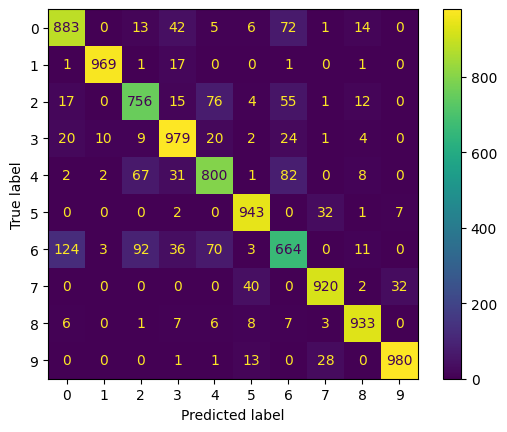

In [34]:
try:
    rf, rf_preds = random_forest(X_train_from_cnn, X_test_from_cnn, y_train_from_cnn, y_test_from_cnn,
              grid_to_search={'max_depth': [10, 15, 20], 'min_samples_leaf': [2, 4, 6],
                              'max_features': list(range(0, int(np.sqrt(X_train_from_cnn.shape[1])), 5)),
                              'n_jobs': [-2]})  # included this to speed up training hopefully?
except BaseException as be:
    import datetime
    now = datetime.datetime.now()
    print(f'{be=}\nAn error occurred. This was raised at approximately {now}.')

MODEL PERFORMANCE:
-------------
accuracy:  0.9005 
precision:  0.8999199206452222 
recall:  0.9004788052573842 
f1-score:  0.8999363467109809


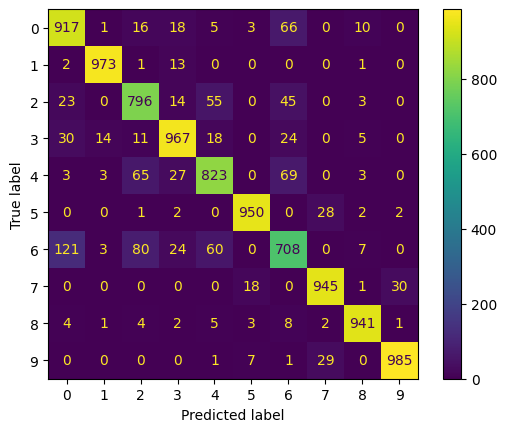

In [35]:
try:
    svm, svm_preds = support_vector_machine(X_train_from_cnn, X_test_from_cnn, y_train_from_cnn, y_test_from_cnn,
                        grid_to_search={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                        'degree': [2, 3, 4, 5],
                                        'gamma': ['scale', 'auto']
                                        })
except BaseException as be:
    import datetime
    now = datetime.datetime.now()
    print(f'{be=}\nAn error occurred. This was raised at approximately {now}.')

MODEL PERFORMANCE:
-------------
accuracy:  0.878 
precision:  0.8771499927977222 
recall:  0.8775553218667514 
f1-score:  0.8768252495968933


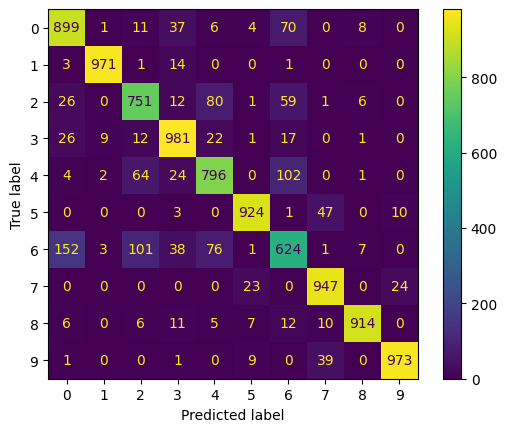

In [36]:
try:
    knn, knn_preds = k_nearest_neighbors(X_train_from_cnn, X_test_from_cnn, y_train_from_cnn, y_test_from_cnn,
                        grid_to_search={'n_neighbors': list(range(1, 10, 2)),
                                        'metric': ['cityblock', 'euclidean', 'manhattan']})
except BaseException as be:
    import datetime
    now = datetime.datetime.now()
    print(f'{be=}\nAn error occurred. This was raised at approximately {now}.')